In [1]:
import torch
from torch import nn
import torchvision
from PIL import Image

from stylegan import G_synthesis

### Load synthesis network and the gaussian fit

In [2]:
generator = G_synthesis().cuda()
generator.load_state_dict(torch.load("models/synthesis.pt"))
gaussian_fit = torch.load("models/gaussian_fit.pt")

In [3]:
img_lr = torchvision.transforms.ToTensor()(Image.open("imgs/ryan128.png")).unsqueeze(0).cuda()
batch_size = 1
img_lr.shape[1:]

torch.Size([3, 128, 128])

In [4]:
lrelu = torch.nn.LeakyReLU(negative_slope=0.2)

#### Noise
Style Gan uses noise to .. TODO
The sizes are TODO

In [5]:
noise = [torch.randn((1, 1, 2**(i//2+2), 2**(i//2+2)), 
              dtype=torch.float, device='cuda', requires_grad=False) 
              for i in range(18)
             ]

In [6]:
#          batch size, latent size, ???
latent = torch.randn((1, 18, 512), dtype=torch.float, requires_grad=True, device='cuda')
optim = torch.optim.Adam([latent], lr=0.4)

In [7]:
mse = nn.MSELoss()
mse = mse.cuda()

for _ in range(100):
   
    optim.zero_grad()
    z = lrelu(latent * gaussian_fit["std"] + gaussian_fit["mean"])

    img_sr = (generator(z, noise) + 1) / 2
    
    img_sr_ds = nn.functional.interpolate(img_sr, img_lr[0].size()[1:], mode='bicubic')
        
    loss = mse(img_lr, img_sr_ds)
  
    loss.backward()
    optim.step()
    

#     with torch.no_grad(): # wrong
#         z.div_(torch.norm(z) + 1e-10)

/home/przm/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [8]:
loss

tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
# torchvision.transforms.ToPILImage()(img_sr[0].cpu())

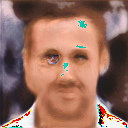

In [14]:
torchvision.transforms.ToPILImage()(img_sr_ds[0].cpu())

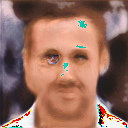

#### Display generated image

In [12]:
# torchvision.transforms.ToPILImage()(img_sr[0].cpu())